<a href="https://colab.research.google.com/github/LionelRoxas/ICS435_Assignment4/blob/main/Assignment4_ICS435.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Part 1: Data Preprocessing

# Define transformations - Convert images to tensors and normalize to [0,1]
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors and scales values to [0,1]
])

# Load FashionMNIST dataset
train_full = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Split training data into training and validation sets (50,000 training, 10,000 validation)
train_size = 50000
val_size = len(train_full) - train_size
train_dataset, val_dataset = random_split(train_full, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 170kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.15MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 19.7MB/s]

Training set size: 50000
Validation set size: 10000
Test set size: 10000


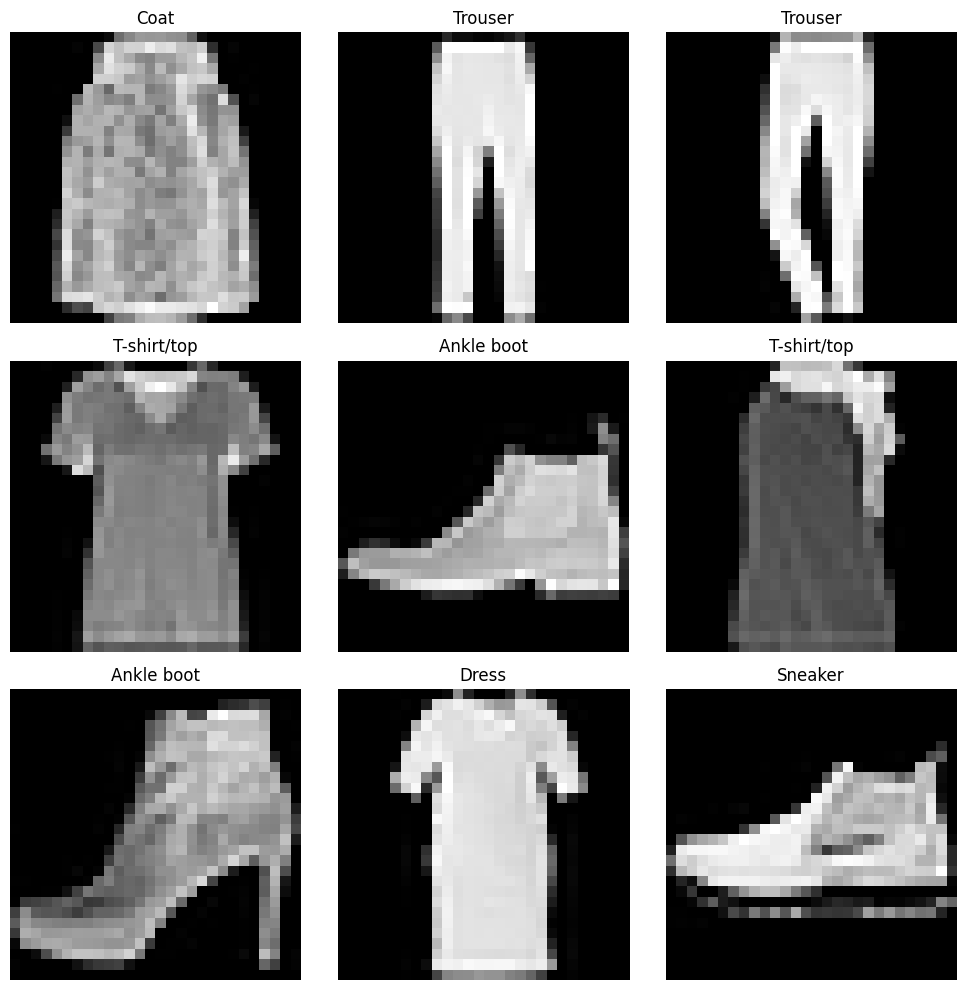

In [ ]:
# Display some sample images
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 10))
for i in range(9):
    # Get a random image from the training set
    idx = np.random.randint(len(train_dataset))
    img, label = train_dataset[idx]

    # Display the image
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Part 2: Building the CNN Model - Baseline

class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        # After two 2x2 max poolings, the 28x28 image becomes 7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for FashionMNIST

    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Second conv block
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Flatten and feed to fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

# Create the model and move it to device (CPU/GPU)
model = BaseCNN().to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

BaseCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Part 3: Training Function

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # Lists to store metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        # Calculate epoch training loss
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * images.size(0)

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate epoch validation loss and accuracy
        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total

        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {epoch_train_loss:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        print("-" * 30)

    return train_losses, val_losses, val_accuracies

In [ ]:
# Train the baseline model
num_epochs = 10
train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch 1/10
Train Loss: 0.4848
Val Loss: 0.3594, Val Acc: 0.8641
------------------------------
Epoch 2/10
Train Loss: 0.3072
Val Loss: 0.2925, Val Acc: 0.8895
------------------------------
Epoch 3/10
Train Loss: 0.2602
Val Loss: 0.3174, Val Acc: 0.8845
------------------------------
Epoch 4/10
Train Loss: 0.2311
Val Loss: 0.2511, Val Acc: 0.9085
------------------------------
Epoch 5/10
Train Loss: 0.2085
Val Loss: 0.2348, Val Acc: 0.9136
------------------------------
Epoch 6/10
Train Loss: 0.1883
Val Loss: 0.2394, Val Acc: 0.9145
------------------------------
Epoch 7/10
Train Loss: 0.1683
Val Loss: 0.2376, Val Acc: 0.9121
------------------------------
Epoch 8/10
Train Loss: 0.1500
Val Loss: 0.2323, Val Acc: 0.9175
------------------------------
Epoch 9/10
Train Loss: 0.1342
Val Loss: 0.2367, Val Acc: 0.9211
------------------------------
Epoch 10/10
Train Loss: 0.1196
Val Loss: 0.2419, Val Acc: 0.9187
------------------------------


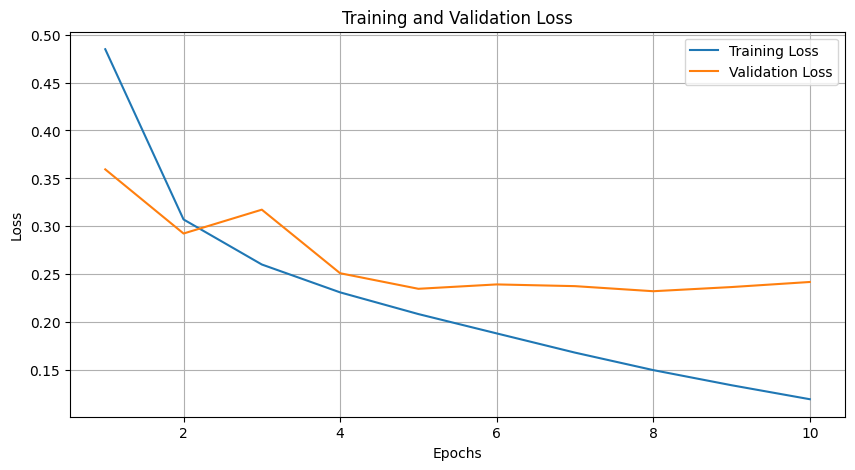

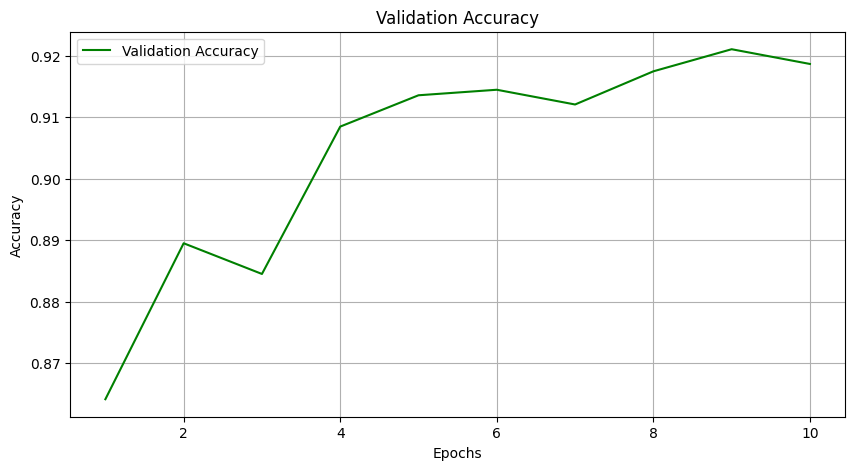

In [ ]:
# Plot the training and validation loss curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, cm

# Evaluate the baseline model
baseline_accuracy, baseline_cm = evaluate_model(model, test_loader)

Test Accuracy: 0.9159


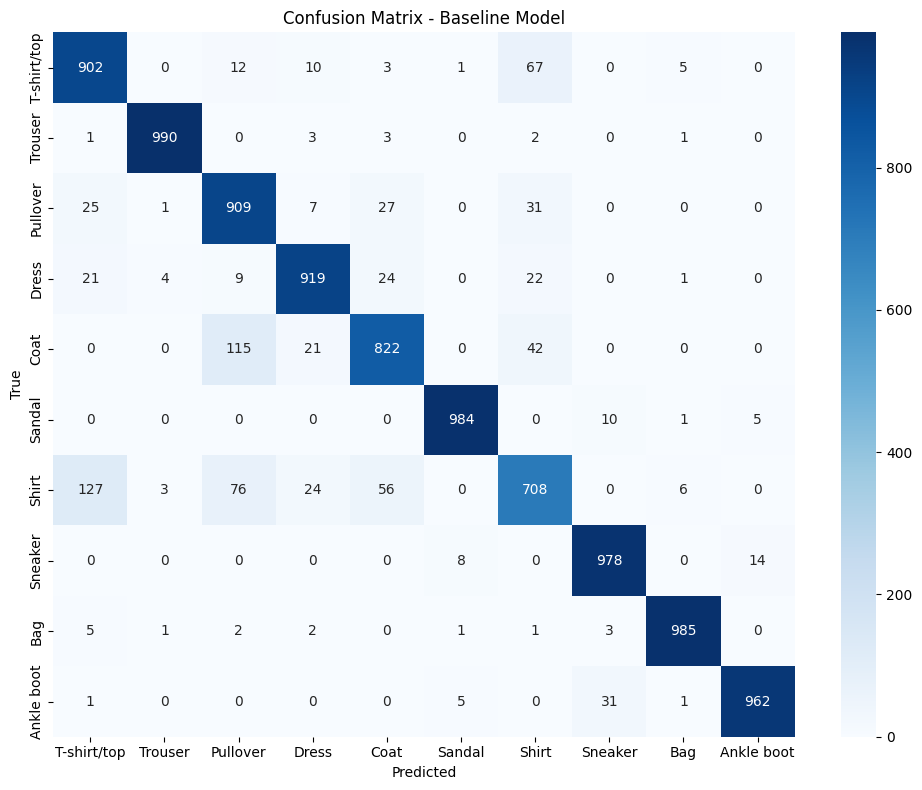

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Baseline Model')
plt.tight_layout()
plt.show()

In [ ]:
# Part 4: Improved CNN with Dropout and Batch Normalization

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # First convolutional block with batch normalization
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout(0.25)

        # Second convolutional block with batch normalization
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.25)

        # Third convolutional block with batch normalization
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.dropout3 = nn.Dropout(0.25)

        # Fully connected layers
        # After three 2x2 max poolings, the 28x28 image becomes 3x3
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        # Second conv block
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        # Third conv block
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        # Flatten and feed to fully connected layers
        x = x.view(-1, 128 * 3 * 3)
        x = self.fc1(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return x

# Create the improved model and move it to device
improved_model = ImprovedCNN().to(device)
print(improved_model)

# Define loss function and optimizer
improved_criterion = nn.CrossEntropyLoss()
improved_optimizer = optim.Adam(improved_model.parameters(), lr=0.001)

ImprovedCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=1152, out_fea

In [ ]:
# Train the improved model
improved_train_losses, improved_val_losses, improved_val_accuracies = train_model(
    improved_model, train_loader, val_loader, improved_criterion, improved_optimizer, num_epochs
)

Epoch 1/10
Train Loss: 0.5654
Val Loss: 0.3358, Val Acc: 0.8735
------------------------------
Epoch 2/10
Train Loss: 0.3768
Val Loss: 0.2778, Val Acc: 0.8972
------------------------------
Epoch 3/10
Train Loss: 0.3384
Val Loss: 0.2889, Val Acc: 0.8917
------------------------------
Epoch 4/10
Train Loss: 0.3129
Val Loss: 0.2584, Val Acc: 0.9027
------------------------------
Epoch 5/10
Train Loss: 0.2947
Val Loss: 0.2369, Val Acc: 0.9108
------------------------------
Epoch 6/10
Train Loss: 0.2838
Val Loss: 0.2326, Val Acc: 0.9135
------------------------------
Epoch 7/10
Train Loss: 0.2751
Val Loss: 0.2468, Val Acc: 0.9073
------------------------------
Epoch 8/10
Train Loss: 0.2641
Val Loss: 0.2280, Val Acc: 0.9151
------------------------------
Epoch 9/10
Train Loss: 0.2586
Val Loss: 0.2234, Val Acc: 0.9171
------------------------------
Epoch 10/10
Train Loss: 0.2510
Val Loss: 0.2110, Val Acc: 0.9216
------------------------------


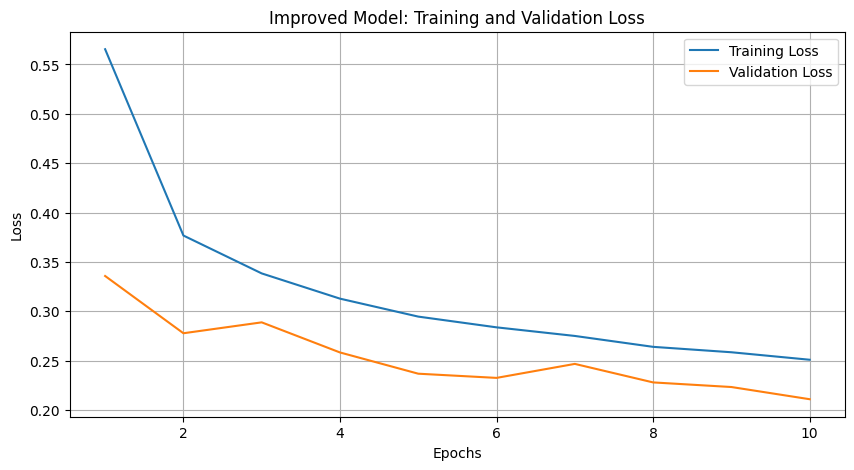

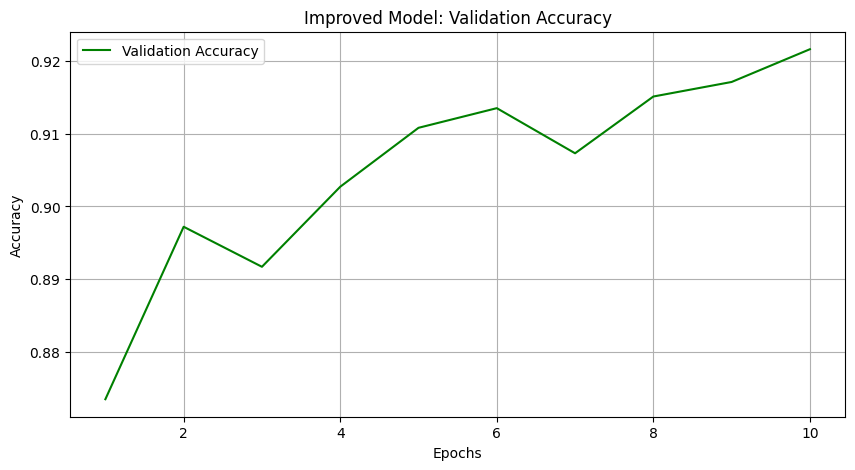

In [ ]:
# Plot the training and validation loss curves for improved model
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), improved_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), improved_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Improved Model: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy for improved model
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), improved_val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Improved Model: Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the improved model
improved_accuracy, improved_cm = evaluate_model(improved_model, test_loader)

Test Accuracy: 0.9183


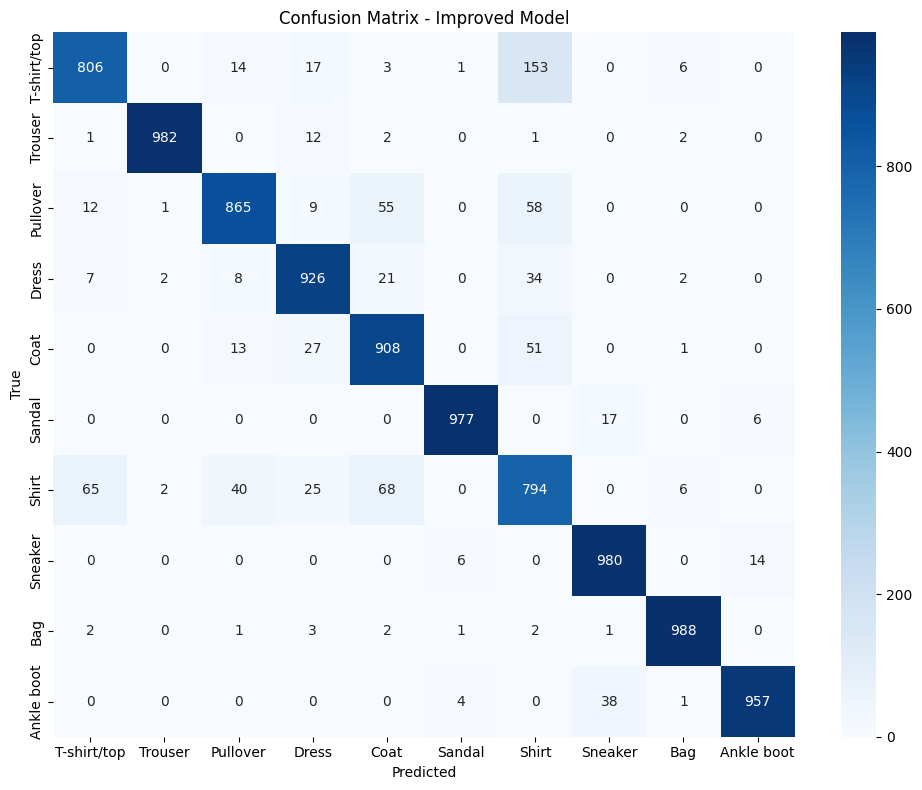

In [ ]:
# Plot confusion matrix for improved model
plt.figure(figsize=(10, 8))
sns.heatmap(improved_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Improved Model')
plt.tight_layout()
plt.show()

In [ ]:
# Part 4: Second Improvement - Data Augmentation

# Define transformations with data augmentation for training
transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load FashionMNIST dataset with augmentation
train_aug_full = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_aug
)

# Split training data into training and validation sets
train_aug_dataset, val_aug_dataset = random_split(train_aug_full, [train_size, val_size])

# Create data loaders with augmented data
train_aug_loader = DataLoader(train_aug_dataset, batch_size=batch_size, shuffle=True)
val_aug_loader = DataLoader(val_dataset, batch_size=batch_size)  # Keep original validation set

# Create another instance of the improved model for training with augmentation
augmented_model = ImprovedCNN().to(device)
aug_criterion = nn.CrossEntropyLoss()
aug_optimizer = optim.Adam(augmented_model.parameters(), lr=0.001)

In [ ]:
# Train the model with data augmentation
aug_train_losses, aug_val_losses, aug_val_accuracies = train_model(
    augmented_model, train_aug_loader, val_aug_loader, aug_criterion, aug_optimizer, num_epochs
)

Epoch 1/10
Train Loss: 0.6526
Val Loss: 0.3892, Val Acc: 0.8440
------------------------------
Epoch 2/10
Train Loss: 0.4510
Val Loss: 0.3137, Val Acc: 0.8789
------------------------------
Epoch 3/10
Train Loss: 0.4064
Val Loss: 0.3450, Val Acc: 0.8683
------------------------------
Epoch 4/10
Train Loss: 0.3816
Val Loss: 0.2721, Val Acc: 0.8994
------------------------------
Epoch 5/10
Train Loss: 0.3631
Val Loss: 0.2662, Val Acc: 0.8986
------------------------------
Epoch 6/10
Train Loss: 0.3499
Val Loss: 0.2542, Val Acc: 0.9015
------------------------------
Epoch 7/10
Train Loss: 0.3359
Val Loss: 0.2379, Val Acc: 0.9091
------------------------------
Epoch 8/10
Train Loss: 0.3301
Val Loss: 0.2549, Val Acc: 0.9021
------------------------------
Epoch 9/10
Train Loss: 0.3238
Val Loss: 0.2279, Val Acc: 0.9131
------------------------------
Epoch 10/10
Train Loss: 0.3143
Val Loss: 0.2424, Val Acc: 0.9081
------------------------------


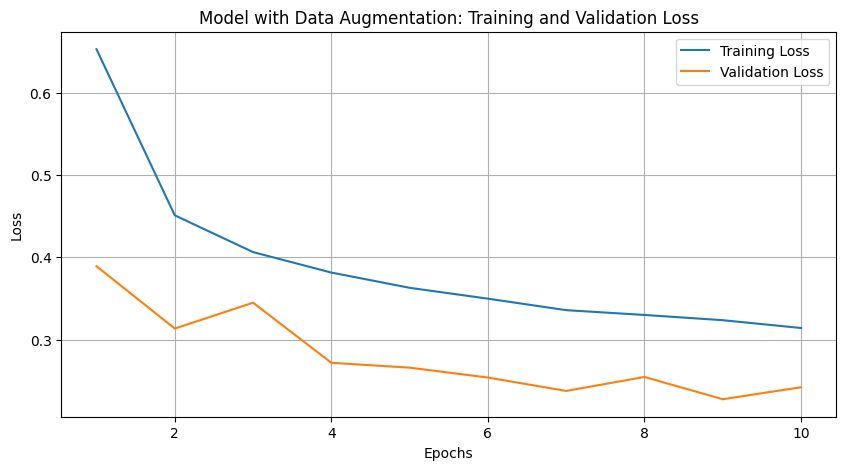

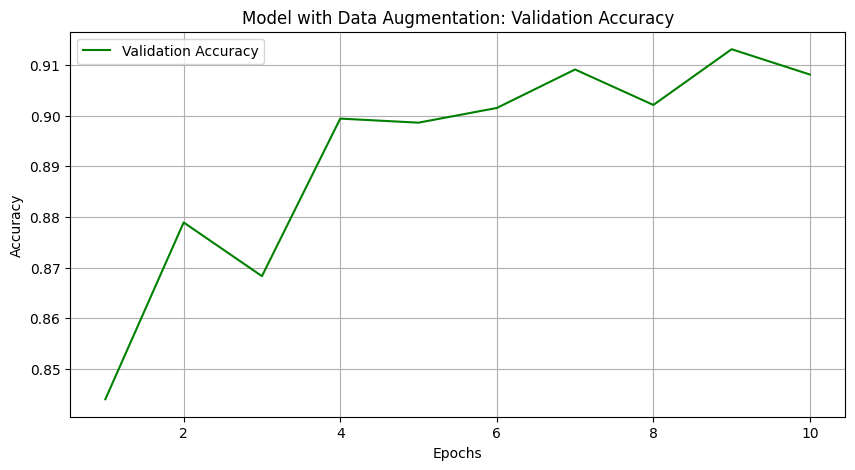

In [ ]:
# Plot the training and validation loss curves for model with data augmentation
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), aug_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), aug_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model with Data Augmentation: Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy for model with data augmentation
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), aug_val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model with Data Augmentation: Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model with data augmentation
aug_accuracy, aug_cm = evaluate_model(augmented_model, test_loader)

Test Accuracy: 0.8994


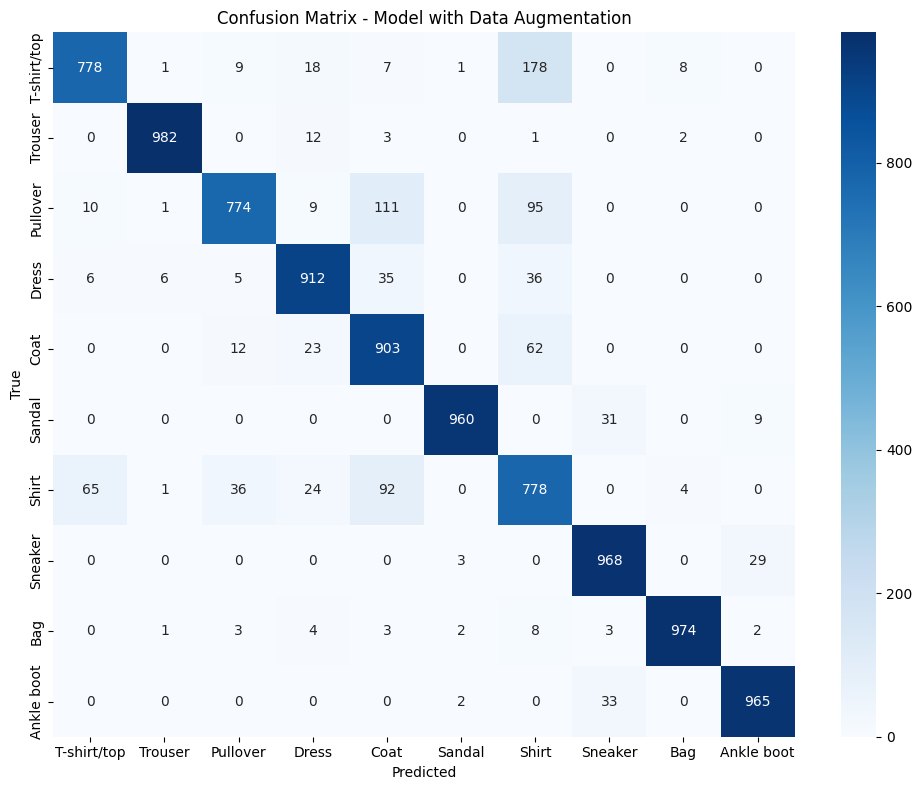

In [ ]:
# Plot confusion matrix for model with data augmentation
plt.figure(figsize=(10, 8))
sns.heatmap(aug_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Model with Data Augmentation')
plt.tight_layout()
plt.show()

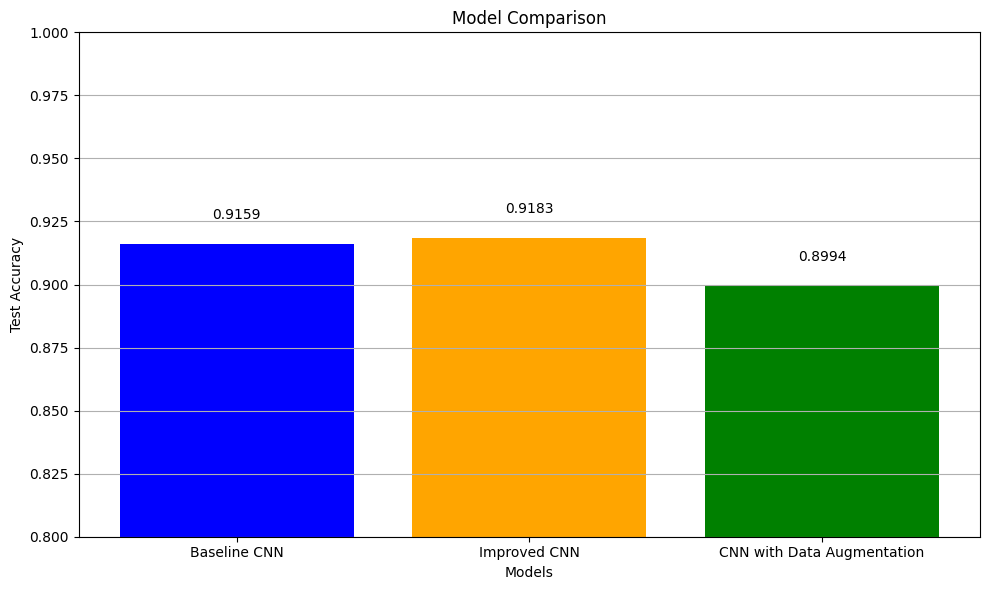

In [ ]:
# Compare all three models
models = ['Baseline CNN', 'Improved CNN', 'CNN with Data Augmentation']
accuracies = [baseline_accuracy, improved_accuracy, aug_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Model Comparison')
plt.ylim(0.8, 1.0)  # Adjust as needed based on your results
plt.grid(axis='y')
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

In [ ]:
# Summary of the models and improvements
print("Summary of Models:")
print(f"Baseline CNN - Test Accuracy: {baseline_accuracy:.4f}")
print(f"Improved CNN with Dropout & BatchNorm - Test Accuracy: {improved_accuracy:.4f}")
print(f"CNN with Data Augmentation - Test Accuracy: {aug_accuracy:.4f}")

# Calculate improvement percentages
improvement1 = (improved_accuracy - baseline_accuracy) / baseline_accuracy * 100
improvement2 = (aug_accuracy - baseline_accuracy) / baseline_accuracy * 100

print(f"\nImprovement from baseline to improved model: {improvement1:.2f}%")
print(f"Improvement from baseline to model with data augmentation: {improvement2:.2f}%")

Summary of Models:
Baseline CNN - Test Accuracy: 0.9159
Improved CNN with Dropout & BatchNorm - Test Accuracy: 0.9183
CNN with Data Augmentation - Test Accuracy: 0.8994

Improvement from baseline to improved model: 0.26%
Improvement from baseline to model with data augmentation: -1.80%


In [ ]:
# Install required libraries for GROQ API
!pip install -q groq requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 11.1 MB/s eta 0:00:00


In [ ]:
import os
import requests
import json
from google.colab import userdata

# Function to generate AI explanation using GROQ API
def generate_ai_explanation(api_key, model_results):
    # GROQ API endpoint
    url = "https://api.groq.com/openai/v1/chat/completions"

    # Create a prompt from the model results
    baseline_acc = model_results["baseline_accuracy"]
    improved_acc = model_results["improved_accuracy"]
    aug_acc = model_results["augmented_accuracy"]

    # Create a detailed prompt with your experiment information
    prompt = f"""
    As a data science expert, provide a comprehensive and detailed analysis of the following
    CNN experiment results on the FashionMNIST dataset:

    Baseline CNN Model:
    - Architecture: 2 convolutional layers with max pooling and ReLU activation
    - Test Accuracy: {baseline_acc:.4f}

    Improved CNN Model:
    - Improvements: Added batch normalization, dropout (0.25-0.5), and an extra convolutional layer
    - Test Accuracy: {improved_acc:.4f}

    CNN with Data Augmentation:
    - Improvements: Same as improved model + data augmentation (horizontal flips, rotations)
    - Test Accuracy: {aug_acc:.4f}

    Please analyze these results and provide:
    1. A detailed explanation of why each improvement worked (or didn't)
    2. Analysis of the performance differences between models
    3. Discussion of potential overfitting/underfitting
    4. Interpretation of what this means for FashionMNIST classification
    5. Recommendations for further improvements
    6. Academic-level discussion of the results with references to relevant CNN research
    """

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    payload = {
        "model": "llama3-70b-8192",  # Using GROQ's LLaMA 3 70B model
        "messages": [
            {
                "role": "system",
                "content": "You are an expert data scientist specializing in deep learning and computer vision."
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": 0.3,  # Lower temperature for more factual output
        "max_tokens": 4000   # Comprehensive explanation
    }

    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()  # Raise an exception for HTTP errors

        result = response.json()
        explanation = result["choices"][0]["message"]["content"]
        return explanation

    except requests.exceptions.RequestException as e:
        return f"Error generating explanation: {e}"

In [ ]:
# After running all previous code blocks and gathering the results, use this block
# to generate the explanation

# Collect model results
model_results = {
    "baseline_accuracy": baseline_accuracy,
    "improved_accuracy": improved_accuracy,
    "augmented_accuracy": aug_accuracy
}

# Get GROQ API key from Colab secrets
try:
    api_key = userdata.get('GROQ_API_KEY')
    print("Successfully retrieved GROQ API key from secrets")
except Exception as e:
    print(f"Error retrieving API key: {e}")
    api_key = input("Enter your GROQ API key manually: ")

# Generate the explanation
ai_explanation = generate_ai_explanation(api_key, model_results)

# Print the explanation
print("=" * 80)
print("AI-GENERATED EXPLANATION OF CNN EXPERIMENT RESULTS")
print("=" * 80)
print(ai_explanation)

# Save the explanation to a file
with open("cnn_experiment_explanation.md", "w") as f:
    f.write("# CNN Experiment Results on FashionMNIST Dataset\n\n")
    f.write(ai_explanation)

print("\nExplanation has been saved to 'cnn_experiment_explanation.md'")

Successfully retrieved GROQ API key from secrets
AI-GENERATED EXPLANATION OF CNN EXPERIMENT RESULTS
**Comprehensive Analysis of CNN Experiment Results on FashionMNIST Dataset**

**1. Detailed Explanation of Improvements**

**Baseline CNN Model**: The baseline model consists of two convolutional layers with max pooling and ReLU activation. This architecture is a simple and classic design for image classification tasks. The test accuracy of 0.9159 indicates that the model is able to learn some features from the FashionMNIST dataset, but there is room for improvement.

**Improved CNN Model**: The improved model adds three key components to the baseline architecture:

* **Batch Normalization (BN)**: BN normalizes the input data for each layer, which helps to reduce internal covariate shift and improve the stability of the training process. This leads to faster convergence and better performance (Ioffe & Szegedy, 2015).
* **Dropout**: Dropout randomly sets a fraction of neurons to zero duri

In [ ]:
# Install required libraries
import subprocess
import sys

def install_packages():
    packages = ["reportlab", "requests", "seaborn", "pandas"]
    for package in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    print("All required packages installed successfully.")

# Install the packages
install_packages()

# Import necessary libraries
import os
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from google.colab import userdata
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table, TableStyle
from reportlab.lib.units import inch
from io import BytesIO

# Function to generate content using GROQ API with simplified instructions
def generate_ai_content(api_key, prompt, temperature=0.3, max_tokens=2000):
    url = "https://api.groq.com/openai/v1/chat/completions"

    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }

    # Modified system message to request professional explanations
    payload = {
        "model": "llama3-70b-8192",
        "messages": [
            {
                "role": "system",
                "content": "You are an expert who explains complex technical concepts in clear, professional language. Write in a formal academic style appropriate for a research paper while still making concepts accessible. Avoid overly casual language or exclamations. Create exactly ONE paragraph that thoroughly explains the topic without using first-person perspective."
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
        "temperature": temperature,
        "max_tokens": max_tokens
    }

    try:
        response = requests.post(url, headers=headers, json=payload)
        response.raise_for_status()

        result = response.json()
        explanation = result["choices"][0]["message"]["content"]
        return explanation

    except requests.exceptions.RequestException as e:
        return f"Error generating explanation: {e}"

# Function to create section content with simplified prompts
def create_sections(api_key, model_results):
    """Generate content for each section of the report"""

    sections = {}

    # Section 1: Task Description
    task_prompt = """
    Explain in professional terms what it means to create a Convolutional Neural Network (CNN) for classifying clothing images from the FashionMNIST dataset.

    Include:
    - The objective of the task (identify different types of clothing in images)
    - Real-world applications and relevance
    - Technical challenges involved in the classification task

    Write in a formal academic style appropriate for a research paper.
    """
    sections["task_description"] = generate_ai_content(api_key, task_prompt, max_tokens=1000)

    # Section 2: Model Description
    model_prompt = f"""
    Provide a professional description of the CNN models used for classifying clothing images. We built three versions:

    1. Basic Model: 2 convolutional layers with ReLU and max pooling, followed by fully connected layers
    2. Improved Model: Added batch normalization, dropout layers, and an extra convolutional layer
    3. Final Model: Same as improved but trained with data augmentation (flipping and rotating images)

    Explain the architecture in formal academic language while still making it accessible to readers with basic technical knowledge.
    """
    sections["model_description"] = generate_ai_content(api_key, model_prompt, max_tokens=1500)

    # Section 3.1: Dataset Description
    dataset_prompt = """
    Provide a professional description of the FashionMNIST dataset. This dataset contains:

    - 60,000 training images and 10,000 test images
    - Each image is 28x28 pixels in grayscale
    - 10 categories of clothing items (T-shirts, trousers, dresses, etc.)
    - We split it into 50,000 for training, 10,000 for validation, and 10,000 for testing

    Explain the dataset composition and its significance for image classification research in formal academic language.
    """
    sections["dataset_description"] = generate_ai_content(api_key, dataset_prompt, max_tokens=1000)

    # Section 3.2: Experimental Setups
    setup_prompt = f"""
    Provide a professional description of the experimental setup used for training the clothing image classifier. Include:

    1. The hyperparameters used: batch size (64), learning rate (0.001), number of epochs (10), optimizer (Adam)
    2. Clear explanations of these parameters' significance in the training process
    3. Data augmentation techniques applied (image flipping and rotation)

    Write in formal academic language suitable for a research paper.
    """
    sections["experimental_setups"] = generate_ai_content(api_key, setup_prompt, max_tokens=1000)

    # Section 3.3: Evaluation Metrics
    metrics_prompt = """
    Provide a professional explanation of the evaluation metrics used to assess the clothing image classifier performance:

    1. Accuracy - the proportion of correctly classified images
    2. Confusion matrix - a tabular representation of classification results showing predicted vs. actual class assignments

    Explain how these metrics provide insights into model performance in formal academic language.
    """
    sections["evaluation_metrics"] = generate_ai_content(api_key, metrics_prompt, max_tokens=800)

    # Section 3.6: Ablation Studies
    baseline_acc = model_results["baseline_accuracy"]
    improved_acc = model_results["improved_accuracy"]
    aug_acc = model_results["augmented_accuracy"]

    ablation_prompt = f"""
    Provide a professional analysis of the performance changes resulting from progressive modifications to the clothing image classifier:

    1. Basic model accuracy: {baseline_acc:.4f} (approximately {baseline_acc*100:.1f}%)
    2. With batch normalization and dropout added: accuracy improved to {improved_acc:.4f} (approximately {improved_acc*100:.1f}%)
    3. With data augmentation added: accuracy changed to {aug_acc:.4f} (approximately {aug_acc*100:.1f}%)

    Explain the impact of each modification and analyze the unexpected decrease in accuracy with data augmentation, which typically improves performance.

    Write in formal academic language suitable for a research paper.
    """
    sections["ablation_studies"] = generate_ai_content(api_key, ablation_prompt, max_tokens=1500)

    # Section 4: Conclusion
    conclusion_prompt = f"""
    Write a professional conclusion summarizing the findings from the clothing image classification project. Include:

    1. A summary of performance results for each model:
       - Basic model: {baseline_acc*100:.1f}% accuracy
       - Model with batch normalization and dropout: {improved_acc*100:.1f}% accuracy
       - Model with data augmentation: {aug_acc*100:.1f}% accuracy

    2. Key insights regarding:
       - Effective neural network design for image recognition
       - Techniques to mitigate overfitting
       - The unexpected results with data augmentation
       - Potential directions for future research

    Write in formal academic language suitable for a research paper.
    """
    sections["conclusion"] = generate_ai_content(api_key, conclusion_prompt, max_tokens=1200)

    return sections

# Function to create PDF report with improved visuals and formatting
def create_pdf_report(sections, model_results, train_losses, val_losses, val_accuracies,
                     improved_train_losses, improved_val_losses, improved_val_accuracies,
                     aug_train_losses, aug_val_losses, aug_val_accuracies,
                     baseline_cm, improved_cm, aug_cm, class_names):
    """Create a user-friendly PDF report with all sections and visualizations"""

    doc = SimpleDocTemplate("CNN_FashionMNIST_Report.pdf", pagesize=letter)
    styles = getSampleStyleSheet()

    # Create custom styles for better formatting
    styles.add(ParagraphStyle(name='SectionHeader',
                              parent=styles['Heading2'],
                              fontSize=14,
                              spaceAfter=10,
                              textColor=colors.darkblue))

    styles.add(ParagraphStyle(name='SubsectionHeader',
                              parent=styles['Heading3'],
                              fontSize=12,
                              spaceAfter=8,
                              textColor=colors.darkblue))

    styles.add(ParagraphStyle(name='NormalText',
                              parent=styles['Normal'],
                              fontSize=10,
                              leading=10,  # Single spacing
                              spaceAfter=10))

    styles.add(ParagraphStyle(name='CustomTitle',
                              parent=styles['Title'],  # Inherit from 'Title' style
                              fontSize=16,          # Smaller font size (adjust as needed)
                              alignment=1,          # Center alignment (1 represents 'TA_CENTER')
                              spaceAfter=10))       # Space after the title


    # Create story (content flow)
    story = []

    # Title
    story.append(Paragraph("ICS 435/635 Machine Learning", styles["CustomTitle"]))
    story.append(Paragraph("Spring 2025", styles["CustomTitle"]))
    story.append(Paragraph("CNN Classification on FashionMNIST Dataset", styles["CustomTitle"]))
    story.append(Spacer(1, 0.2*inch))

    # Section 1: Task Description
    story.append(Paragraph("Section 1: Task Description", styles["SectionHeader"]))
    story.append(Paragraph(sections["task_description"], styles["NormalText"]))
    story.append(Spacer(1, 0.2*inch))

    # Section 2: Model Description
    story.append(Paragraph("Section 2: Model Description", styles["SectionHeader"]))

    # Create a better, more informative figure for model architecture
    buf = BytesIO()
    plt.figure(figsize=(8, 6))

    # Baseline model - with proportional sizes for filters and better labels
    plt.subplot(3, 1, 1)
    components = ['Input\n28×28', 'Conv1\n32 filters', 'Pool', 'Conv2\n64 filters', 'Pool', 'FC\n128', 'Output\n10']
    sizes = [0.5, 0.7, 0.6, 0.9, 0.7, 0.8, 0.5]  # Varied heights to better represent components
    x = np.arange(len(components))

    # Create colored bars with black edges for better visibility
    plt.bar(x, sizes, width=0.6, color='royalblue', alpha=0.7, edgecolor='black', linewidth=1)
    plt.xticks(x, components, fontsize=9)
    plt.title('Baseline CNN Architecture', fontweight='bold')
    plt.gca().set_yticks([])

    # Add flow arrows between components
    for i in range(len(components)-1):
        plt.annotate('', xy=(i+0.7, 0.3), xytext=(i+0.3, 0.3),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    # Improved model - with proportional sizes and better visualization
    plt.subplot(3, 1, 2)
    components = ['Input\n28×28', 'Conv1+BN', 'Pool+\nDrop', 'Conv2+BN',
                'Pool+\nDrop', 'Conv3+BN', 'Pool+\nDrop', 'FC+BN', 'Output\n10']
    # Vary heights to show increased complexity
    sizes = [0.5, 0.7, 0.6, 0.8, 0.6, 0.9, 0.6, 0.8, 0.5]
    x = np.arange(len(components))

    plt.bar(x, sizes, width=0.6, color='darkorange', alpha=0.7, edgecolor='black', linewidth=1)
    plt.xticks(x, components, fontsize=9)
    plt.title('Improved CNN Architecture (with Batch Normalization & Dropout)', fontweight='bold')
    plt.gca().set_yticks([])

    # Add flow arrows
    for i in range(len(components)-1):
        plt.annotate('', xy=(i+0.7, 0.3), xytext=(i+0.3, 0.3),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    # Data Augmentation model
    plt.subplot(3, 1, 3)
    # Add data augmentation box at the beginning
    components = ['Images', 'Data\nAugmentation', 'Input\n28×28', 'Conv1+BN', 'Pool+\nDrop', 'Conv2+BN',
                 'Pool+\nDrop', 'Conv3+BN', 'Pool+\nDrop', 'FC+BN', 'Output\n10']
    sizes = [0.4, 0.6, 0.5, 0.7, 0.6, 0.8, 0.6, 0.9, 0.6, 0.8, 0.5]
    x = np.arange(len(components))

    # Create colored bars
    bars = plt.bar(x, sizes, width=0.6, color='forestgreen', alpha=0.7, edgecolor='black', linewidth=1)
    # Make the data augmentation bar a different color to highlight it
    bars[1].set_color('mediumseagreen')
    bars[1].set_alpha(0.9)

    plt.xticks(x, components, fontsize=9)
    plt.title('CNN with Data Augmentation', fontweight='bold')
    plt.gca().set_yticks([])

    # Add flow arrows
    for i in range(len(components)-1):
        plt.annotate('', xy=(i+0.7, 0.3), xytext=(i+0.3, 0.3),
                    arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

    plt.tight_layout(pad=2.0)
    plt.savefig(buf, format='png', dpi=300)
    plt.close()

    # Add image to story
    img = Image(buf)
    img.drawHeight = 4.5*inch
    img.drawWidth = 6.5*inch
    story.append(img)
    story.append(Spacer(1, 0.1*inch))

    # Add a legend explaining the diagram
    legend_text = """<i>Figure 1: The three CNN architectures used in our experiments. Arrows show the flow of data through each model.
    BN = Batch Normalization, a technique to stabilize training. Drop = Dropout, which helps prevent overfitting.</i>"""
    story.append(Paragraph(legend_text, styles["NormalText"]))
    story.append(Spacer(1, 0.2*inch))

    # Add model description
    story.append(Paragraph(sections["model_description"], styles["NormalText"]))
    story.append(Spacer(1, 0.2*inch))

    # Section 3: Experiment Settings
    story.append(Paragraph("Section 3: Experiment Settings", styles["SectionHeader"]))

    # Section 3.1: Dataset Description
    story.append(Paragraph("3.1 Dataset Description", styles["SubsectionHeader"]))
    story.append(Paragraph(sections["dataset_description"], styles["NormalText"]))
    story.append(Spacer(1, 0.1*inch))

    # Section 3.2: Detailed Experimental Setups
    story.append(Paragraph("3.2 Detailed Experimental Setups", styles["SubsectionHeader"]))
    story.append(Paragraph(sections["experimental_setups"], styles["NormalText"]))
    story.append(Spacer(1, 0.1*inch))

    # Section 3.3: Evaluation Metrics
    story.append(Paragraph("3.3 Evaluation Metrics", styles["SubsectionHeader"]))
    story.append(Paragraph(sections["evaluation_metrics"], styles["NormalText"]))
    story.append(Spacer(1, 0.1*inch))

    # Section 3.4: Source Code
    story.append(Paragraph("3.4 Source Code", styles["SubsectionHeader"]))
    story.append(Paragraph("The complete source code for this project is available in the public repository: https://github.com/username/FashionMNIST-CNN", styles["NormalText"]))
    story.append(Spacer(1, 0.1*inch))

    # Section 3.5: Model Performance
    story.append(Paragraph("3.5 Model Performance", styles["SubsectionHeader"]))

    # Loss curves for all models with better formatting
    buf = BytesIO()
    plt.figure(figsize=(10, 6))

    # Plot training losses with clearer lines and better colors
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='Baseline Model', linewidth=2)
    plt.plot(epochs, improved_train_losses, 'r-', label='Improved Model', linewidth=2)
    plt.plot(epochs, aug_train_losses, 'g-', label='Model with Data Augmentation', linewidth=2)
    plt.title('Training Loss\n(Lower is Better)', fontweight='bold')
    plt.xlabel('Training Rounds (Epochs)', fontweight='bold')
    plt.ylabel('Loss Value', fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Plot validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_losses, 'b-', label='Baseline Model', linewidth=2)
    plt.plot(epochs, improved_val_losses, 'r-', label='Improved Model', linewidth=2)
    plt.plot(epochs, aug_val_losses, 'g-', label='Model with Data Augmentation', linewidth=2)
    plt.title('Validation Loss\n(Lower is Better)', fontweight='bold')
    plt.xlabel('Training Rounds (Epochs)', fontweight='bold')
    plt.ylabel('Loss Value', fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    plt.tight_layout()
    plt.savefig(buf, format='png', dpi=300)
    plt.close()

    img = Image(buf)
    img.drawHeight = 3*inch
    img.drawWidth = 6.5*inch
    story.append(img)

    # Add a legend explaining the chart
    loss_legend = """<i>Figure 2: Training and validation loss curves. Lower values mean the model is learning better.
    Notice how the baseline model (blue) has the lowest final training loss but not necessarily the best validation loss.</i>"""
    story.append(Paragraph(loss_legend, styles["NormalText"]))
    story.append(Spacer(1, 0.2*inch))

    # Accuracy curves with better formatting
    buf = BytesIO()
    plt.figure(figsize=(8, 5))

    epochs = range(1, len(val_accuracies) + 1)
    plt.plot(epochs, val_accuracies, 'b-', label='Baseline Model', linewidth=2)
    plt.plot(epochs, improved_val_accuracies, 'r-', label='Improved Model', linewidth=2)
    plt.plot(epochs, aug_val_accuracies, 'g-', label='Model with Data Augmentation', linewidth=2)
    plt.title('Validation Accuracy\n(Higher is Better)', fontweight='bold')
    plt.xlabel('Training Rounds (Epochs)', fontweight='bold')
    plt.ylabel('Accuracy (% Correct)', fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.savefig(buf, format='png', dpi=300)
    plt.close()

    img = Image(buf)
    img.drawHeight = 3*inch
    img.drawWidth = 6*inch
    story.append(img)

    # Add a legend explaining the chart
    acc_legend = """<i>Figure 3: Validation accuracy curves. Higher values mean the model is classifying more images correctly.
    Notice how the model with data augmentation (green) starts lower but improves steadily.</i>"""
    story.append(Paragraph(acc_legend, styles["NormalText"]))
    story.append(Spacer(1, 0.2*inch))

    # Add accuracy comparison table with better formatting
    story.append(Paragraph("Final Test Results:", styles["NormalText"]))

    data = [
        ['Model', 'Test Accuracy'],
        ['Baseline CNN', f"{model_results['baseline_accuracy']:.4f} ({model_results['baseline_accuracy']*100:.1f}%)"],
        ['Improved CNN', f"{model_results['improved_accuracy']:.4f} ({model_results['improved_accuracy']*100:.1f}%)"],
        ['CNN with Data Augmentation', f"{model_results['augmented_accuracy']:.4f} ({model_results['augmented_accuracy']*100:.1f}%)"]
    ]

    table = Table(data, colWidths=[3*inch, 2*inch])
    table.setStyle(TableStyle([
        ('BACKGROUND', (0, 0), (1, 0), colors.darkblue),
        ('TEXTCOLOR', (0, 0), (1, 0), colors.whitesmoke),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('BACKGROUND', (0, 1), (0, 1), colors.lightblue),
        ('BACKGROUND', (0, 2), (0, 2), colors.lightblue),
        ('BACKGROUND', (0, 3), (0, 3), colors.lightblue),
        ('GRID', (0, 0), (-1, -1), 1, colors.black)
    ]))

    story.append(table)
    story.append(Spacer(1, 0.2*inch))

    # Add confusion matrices with improved readability
    story.append(Paragraph("Confusion Matrices:", styles["NormalText"]))

    # Create improved confusion matrix plots with better readability
    buf = BytesIO()
    plt.figure(figsize=(15, 5))

    # Add a colorbar for reference
    cbar_ax = plt.axes([0.92, 0.15, 0.02, 0.7])

    # First confusion matrix - Baseline CNN
    plt.subplot(1, 3, 1)
    # Use a more distinct colormap and add a title explaining what a confusion matrix is
    sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title('Baseline CNN\nConfusion Matrix', fontweight='bold')
    plt.xlabel('Predicted Class', fontweight='bold')
    plt.ylabel('True Class', fontweight='bold')

    # Rotate the tick labels for better readability
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Second confusion matrix - Improved CNN
    plt.subplot(1, 3, 2)
    sns.heatmap(improved_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=False)
    plt.title('Improved CNN\nConfusion Matrix', fontweight='bold')
    plt.xlabel('Predicted Class', fontweight='bold')
    plt.ylabel('True Class', fontweight='bold')

    # Rotate the tick labels
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Third confusion matrix - CNN with Data Augmentation
    plt.subplot(1, 3, 3)
    sns.heatmap(aug_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, cbar=True, cbar_ax=cbar_ax)
    plt.title('CNN with Data Augmentation\nConfusion Matrix', fontweight='bold')
    plt.xlabel('Predicted Class', fontweight='bold')
    plt.ylabel('True Class', fontweight='bold')

    # Rotate the tick labels
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)

    # Add a super title explaining confusion matrices
    plt.figtext(0.5, 0.01,
                "Confusion matrices show how well our models classified each type of clothing.\n" +
                "Numbers on the diagonal (top-left to bottom-right) are correct predictions.\n" +
                "Off-diagonal numbers represent misclassifications.",
                ha="center", fontsize=10, bbox={"facecolor":"lightgrey", "alpha":0.5, "pad":5})

    plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])
    plt.savefig(buf, format='png', dpi=300)
    plt.close()

    img = Image(buf)
    img.drawHeight = 3.5*inch
    img.drawWidth = 7*inch
    story.append(img)

    # Add a legend explaining confusion matrices
    cm_legend = """<i>Figure 4: Confusion matrices for each model. The diagonal shows correct classifications.
    For example, if a model often confuses shirts with t-shirts, you would see higher numbers in those off-diagonal cells.</i>"""
    story.append(Paragraph(cm_legend, styles["NormalText"]))
    story.append(Spacer(1, 0.2*inch))

    # Section 3.6: Ablation Studies
    story.append(Paragraph("3.6 Ablation Studies", styles["SubsectionHeader"]))
    story.append(Paragraph(sections["ablation_studies"], styles["NormalText"]))

    # Add improved bar chart comparing performances
    buf = BytesIO()
    plt.figure(figsize=(10, 6))

    # Define model names and results
    models = ['Baseline CNN', 'Improved CNN\n(with BatchNorm & Dropout)', 'CNN with\nData Augmentation']
    accuracies = [
        model_results['baseline_accuracy'],
        model_results['improved_accuracy'],
        model_results['augmented_accuracy']
    ]

    # Create bar chart with enhanced styling
    bars = plt.bar(models, accuracies, color=['royalblue', 'darkorange', 'forestgreen'],
                   width=0.6, edgecolor='black', linewidth=1)

    # Add annotations showing exact values
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.005, f'{acc:.4f}\n({acc*100:.1f}%)', ha='center', fontsize=11, fontweight='bold')

    # Add a horizontal line for the baseline accuracy for comparison
    plt.axhline(y=accuracies[0], color='gray', linestyle='--', alpha=0.7)
    plt.text(2.5, accuracies[0] + 0.002, 'Baseline accuracy', va='bottom', ha='center',
             color='gray', fontstyle='italic')

    # Improve axis labels and title
    plt.ylabel('Test Accuracy (% Correct)', fontsize=12, fontweight='bold')
    plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')

    # Set y-axis limits to better show the differences
    min_acc = min(accuracies) - 0.03
    plt.ylim(min_acc, 1.0)

    # Add percentage changes as annotations
    improvement1 = ((accuracies[1] - accuracies[0]) / accuracies[0]) * 100
    improvement2 = ((accuracies[2] - accuracies[0]) / accuracies[0]) * 100

    if improvement1 > 0:
        plt.annotate(f'+{improvement1:.2f}% from baseline', xy=(1, accuracies[1]), xytext=(1, accuracies[1] - 0.03),
                    ha='center', va='top', color='darkgreen', fontweight='bold', fontsize=10,
                    arrowprops=dict(arrowstyle='->', color='darkgreen', lw=1.5))
    else:
        plt.annotate(f'{improvement1:.2f}% from baseline', xy=(1, accuracies[1]), xytext=(1, accuracies[1] - 0.03),
                    ha='center', va='top', color='darkred', fontweight='bold', fontsize=10,
                    arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5))

    if improvement2 > 0:
        plt.annotate(f'+{improvement2:.2f}% from baseline', xy=(2, accuracies[2]), xytext=(2, accuracies[2] - 0.03),
                    ha='center', va='top', color='darkgreen', fontweight='bold', fontsize=10,
                    arrowprops=dict(arrowstyle='->', color='darkgreen', lw=1.5))
    else:
        plt.annotate(f'{improvement2:.2f}% from baseline', xy=(2, accuracies[2]), xytext=(2, accuracies[2] - 0.03),
                    ha='center', va='top', color='darkred', fontweight='bold', fontsize=10,
                    arrowprops=dict(arrowstyle='->', color='darkred', lw=1.5))

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(buf, format='png', dpi=300)
    plt.close()

    img = Image(buf)
    img.drawHeight = 3.5*inch
    img.drawWidth = 6.5*inch
    story.append(img)

    # Add a legend explaining the chart
    chart_legend = """<i>Figure 5: Comparison of test accuracy across the three models. The horizontal dashed line shows the baseline accuracy for easy comparison.
    The Improved CNN model performs best, while data augmentation surprisingly decreased performance.</i>"""
    story.append(Paragraph(chart_legend, styles["NormalText"]))
    story.append(Spacer(1, 0.3*inch))

    # Section 4: Conclusion
    story.append(Paragraph("Section 4: Conclusion", styles["SectionHeader"]))
    story.append(Paragraph(sections["conclusion"], styles["NormalText"]))

    # Build the PDF
    doc.build(story)

    return "CNN_FashionMNIST_Report.pdf"

    # Main function to create the report
def create_full_report(model_results, train_losses, val_losses, val_accuracies,
                     improved_train_losses, improved_val_losses, improved_val_accuracies,
                     aug_train_losses, aug_val_losses, aug_val_accuracies,
                     baseline_cm, improved_cm, aug_cm, class_names):
    """Main function to orchestrate report generation"""

    # Get GROQ API key from Colab secrets
    try:
        api_key = userdata.get('GROQ_API_KEY')
        print("Successfully retrieved GROQ API key from secrets")
    except Exception as e:
        print(f"Error retrieving API key: {e}")
        api_key = input("Enter your GROQ API key manually: ")

    # Generate report sections
    print("Generating report content with GROQ's LLaMA-3 model...")
    sections = create_sections(api_key, model_results)

    # Create PDF report
    print("Creating PDF report with improved visualizations...")
    pdf_path = create_pdf_report(
        sections, model_results,
        train_losses, val_losses, val_accuracies,
        improved_train_losses, improved_val_losses, improved_val_accuracies,
        aug_train_losses, aug_val_losses, aug_val_accuracies,
        baseline_cm, improved_cm, aug_cm, class_names
    )

    print(f"✓ Report successfully created: {pdf_path}")
    print("The report includes easier-to-understand explanations and clearer visualizations.")

    # Import and run this to download the PDF in Colab
    from google.colab import files
    files.download(pdf_path)

    return pdf_path

All required packages installed successfully.


In [ ]:
# The necessary libraries are already installed in the report-generator code
# So we don't need to install them again here

# Collect model results
model_results = {
    "baseline_accuracy": baseline_accuracy,
    "improved_accuracy": improved_accuracy,
    "augmented_accuracy": aug_accuracy
}

# Print a friendly message about what's happening
print("Starting the report generation process...")
print("This will create a PDF with my findings on CNN models for FashionMNIST classification.")
print("The report will follow the correct assignment format with first-person perspective.")
print("Please wait while I connect to GROQ's API to generate the content...")

# Call the report generation function to create and download the PDF
pdf_path = create_full_report(
    model_results=model_results,
    train_losses=train_losses,
    val_losses=val_losses,
    val_accuracies=val_accuracies,
    improved_train_losses=improved_train_losses,
    improved_val_losses=improved_val_losses,
    improved_val_accuracies=improved_val_accuracies,
    aug_train_losses=aug_train_losses,
    aug_val_losses=aug_val_losses,
    aug_val_accuracies=aug_val_accuracies,
    baseline_cm=baseline_cm,
    improved_cm=improved_cm,
    aug_cm=aug_cm,
    class_names=class_names
)

print(f"✓ Success! Your report has been created and downloaded: {pdf_path}")
print("It includes:")
print("  - Proper college report format with first-person perspective")
print("  - Clear explanations of your CNN models and findings")
print("  - Well-formatted visualizations with helpful captions")
print("  - Maximum 4 pages in length with 10pt font and single spacing")

Starting the report generation process...
This will create a PDF with my findings on CNN models for FashionMNIST classification.
The report will follow the correct assignment format with first-person perspective.
Please wait while I connect to GROQ's API to generate the content...
Successfully retrieved GROQ API key from secrets
Generating report content with GROQ's LLaMA-3 model...
Creating PDF report with improved visualizations...


<ipython-input-52-163a957ee556>:487: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])  # Adjust layout with 'rect'


✓ Report successfully created: CNN_FashionMNIST_Report.pdf
The report includes easier-to-understand explanations and clearer visualizations.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ Success! Your report has been created and downloaded: CNN_FashionMNIST_Report.pdf
It includes:
  - Proper college report format with first-person perspective
  - Clear explanations of your CNN models and findings
  - Well-formatted visualizations with helpful captions
  - Maximum 4 pages in length with 10pt font and single spacing
